In [27]:
import os
import numpy as np
import pandas as pd

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings(action = 'ignore')

import pickle

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import seaborn as sns

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)

# 데이터 불러오기
ratings_cols = ['user_id', 'item_id', 'rating', 'timestamp']
movie_cols = ['item_id', 'title', 'genre'] 

ratings = pd.read_csv('/home/ryu/thesis/data/ml-1m/ratings.dat', sep='::', names=ratings_cols, engine='python', encoding = "ISO-8859-1")
movies = pd.read_csv('/home/ryu/thesis/data/ml-1m/movies.dat', sep='::', names=movie_cols, engine='python', encoding = "ISO-8859-1")

# 평점 없는 영화 제거
movies_in_rating = ratings['item_id'].unique()
movies = movies[movies['item_id'].isin(movies_in_rating)]

In [2]:
ratings.shape

(1000209, 4)

# train_test_split

In [2]:
# # 각 사용자별로 시간 순으로 데이터를 정렬합니다.
# ratings_sorted = ratings.sort_values(by=['user_id', 'timestamp'])

# # 사용자별로 데이터를 분할하여 훈련 데이터와 테스트 데이터를 생성합니다.
# train_data = pd.DataFrame()
# test_data = pd.DataFrame()

# # 데이터 분할
# for user_id, group in ratings_sorted.groupby('user_id'):
#     split_point = int(len(group) * 0.75)  # 80% 지점을 계산합니다.
#     user_train = group.iloc[:split_point]
#     user_test = group.iloc[split_point:]
    
#     train_data = train_data.append(user_train)
#     test_data = test_data.append(user_test)

# ratings_train = train_data.copy()
# ratings_test = test_data.copy()

In [28]:
# Rating 데이터를 test, train으로 나누기
x = ratings.copy()
y = ratings['user_id']
ratings_train, ratings_test = train_test_split(x, test_size=0.25, stratify=y, random_state=15)

In [3]:
# 나누어진 train, test set 저장
# ratings_train.to_csv('/home/ryu/thesis/test_movielens/basic_cosine/0_train.csv')
# ratings_test.to_csv('/home/ryu/thesis/test_movielens/basic_cosine/0_test.csv')

In [2]:
# ratings_train = pd.read_csv('/home/ryu/thesis/test_movielens/datasets_n_baseline/0_train.csv', index_col=0)
# ratings_test = pd.read_csv('/home/ryu/thesis/test_movielens/datasets_n_baseline/0_test.csv', index_col=0)

# baseline

In [29]:
class MF_base():
    ##### CLASS INITIALIZATION AND INDEXING ######
    def __init__(self, ratings, K, alpha, beta, iterations, tolerance=0.005, verbose=True):
        """
        Initialize the MF_base object.
        
        :param ratings: DataFrame, user-item interaction data
        :param K: int, number of latent features
        :param alpha: float, learning rate
        :param beta: float, regularization parameter
        :param iterations: int, number of iterations for stochastic gradient descent
        :param tolerance: float, early stopping tolerance for RMSE increase
        :param verbose: bool, whether to print progress messages
        """
        # Convert the user-item matrix to a numpy array
        self.R = np.array(ratings)
        # Map user and item IDs to indices
        self.user_id_index = {user_id: i for i, user_id in enumerate(ratings.index)}
        self.item_id_index = {item_id: i for i, item_id in enumerate(ratings.columns)}
        self.index_user_id = {i: user_id for user_id, i in self.user_id_index.items()}
        self.index_item_id = {i: item_id for item_id, i in self.item_id_index.items()}
        # initialize other variables
        self.num_users, self.num_items = self.R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.tolerance = tolerance
        self.verbose = verbose
        
        # Placeholder for the test set
        self.test_set = None
    
    ##### TESTING AND RMSE CALCULATION #####
    def set_test(self, ratings_test):
        """
        Set the test dataset and update the user-item matrix to exclude test ratings.
        
        :param ratings_test: DataFrame, the testing data
        :return: list, the test dataset with user and item indices and ratings
        """
        test_set = []
        for _, row in ratings_test.iterrows():
            user_idx = self.user_id_index.get(row['user_id'], None)
            item_idx = self.item_id_index.get(row['item_id'], None)
            
            if user_idx is not None and item_idx is not None:
                test_set.append([user_idx, item_idx, row['rating']])
                self.R[user_idx, item_idx] = 0  # Set the rating to 0 in the training data
        
        self.test_set = test_set
        return test_set

    def train(self, allow_increase=5):
        """
        Train the model using stochastic gradient descent and calculate train and test RMSE.
        
        :param allow_increase: int, allowed number of iterations with RMSE increase
        :return: list, training process with iteration, train RMSE, and test RMSE
        """
        # Initialize user-feature and item-feature matrices
        ### set the standard deviation to 1/self.K for faster and more stable convergence
        ### Gaussian distribution
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # Initialize bias terms
        self.b_u = np.zeros(self.num_users)        # user bias
        self.b_d = np.zeros(self.num_items)        # item bias
        self.b = np.mean(self.R[self.R.nonzero()]) # 모든 아이템 평점 평균

        # List of training samples
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i, j]) for i, j in zip(rows, columns)]

        # Stochastic gradient descent
        best_RMSE = float('inf')
        best_iteration = 0
        training_process = []
        increase_count = 0
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            train_rmse = self.rmse()
            test_rmse = self.test_rmse()
            training_process.append((i, train_rmse, test_rmse))
            
            if self.verbose and (i + 1) % 10 == 0:
                print(f"Iteration: {i + 1} ; Train RMSE: {train_rmse:.6f} ; Test RMSE: {test_rmse:.6f}")
                
            if test_rmse < best_RMSE:
                best_RMSE = test_rmse
                best_iteration = i
                increase_count = 0  # Reset the increase count
            elif (test_rmse - best_RMSE) > self.tolerance:
                increase_count += 1
                if increase_count > allow_increase:
                    break  # Stop if RMSE increases for more than 'allow_increase' consecutive iterations

        print(f"Best Iteration: {best_iteration} ; Best Test RMSE: {best_RMSE:.6f}")
        return best_iteration, best_RMSE
    
    def sgd(self):
        """
        Perform stochastic gradient descent.
        """
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i, :])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j, :])
            
    def rmse(self):
        """
        Calculate root mean square error on the training data.
        
        :return: float, the RMSE value
        """
        predictions = self.R.copy()
        rows, cols = self.R.nonzero()
        for i, j in zip(rows, cols):
            predictions[i, j] = self.get_prediction(i, j)
            
        errors = [(self.R[i, j] - predictions[i, j]) for i, j in zip(rows, cols) if self.R[i, j] > 0]
        return np.sqrt(np.mean(np.array(errors) ** 2))
    
    def test_rmse(self):
        """
        Calculate root mean square error on the test data.
        
        :return: float, the RMSE value
        """
        error = 0
        for user_idx, item_idx, rating in self.test_set:
            predicted = self.get_prediction(user_idx, item_idx)
            error += (rating - predicted) ** 2
        return np.sqrt(error / len(self.test_set))

    ##### PREDICTION #####
    def get_prediction(self, i, j):
        """
        Get the predicted rating for a given user and item index.
        
        :param i: int, user index
        :param j: int, item index
        :return: float, predicted rating
        """
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    
    def get_one_prediction(self, user_id, item_id):
        """
        Get the predicted rating for a given user ID and item ID.
        
        :param user_id: str or int, user ID
        :param item_id: str or int, item ID
        :return: float or str, predicted rating or error message
        """
        user_idx = self.user_id_index.get(user_id, None)
        item_idx = self.item_id_index.get(item_id, None)
        
        if user_idx is not None and item_idx is not None:
            return self.get_prediction(user_idx, item_idx)
        else:
            return "User or Item ID not found in training data"

In [ ]:
# # 모델 학습
# R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
# model = MF_base(R_temp, K=220, alpha=0.0024, beta=0.05, iterations=400, tolerance=0.0005, verbose=True)
# test_set = model.set_test(ratings_test)
# result = model.train()

In [ ]:
# # Save model results
# with open('/home/ryu/thesis/new_movielens/8_model.pkl', 'wb') as f:
#     pickle.dump(model, f)

In [30]:
# Open saved model
with open('/home/ryu/thesis/new_movielens/15_model.pkl', 'rb') as f:
    model = pickle.load(f)

# black sheep identification

In [34]:
# 공통 아이템 수 계산 함수
def calculate_common_items(ratings):
    user_items = ratings.groupby('user_id')['item_id'].apply(set)
    common_items_count = {user: {} for user in user_items.keys()}

    for user1 in user_items.keys():
        for user2 in user_items.keys():
            if user1 != user2:  # 중복 계산 방지
                common_items = user_items[user1].intersection(user_items[user2])
                common_items_count[user1][user2] = len(common_items)
                
    return common_items_count

In [35]:
# 위 함수를 사용하여 공통 아이템 수 계산
common_items_count = calculate_common_items(ratings)

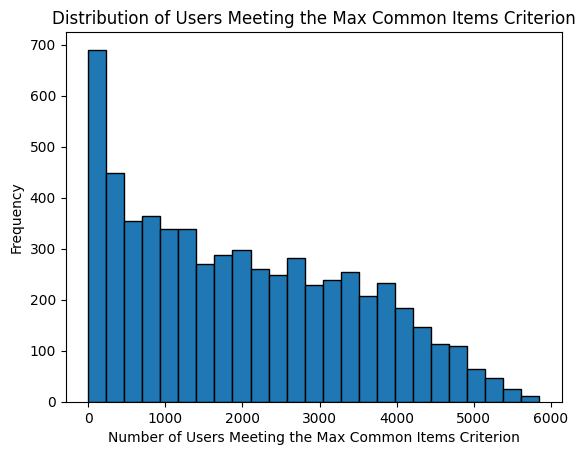

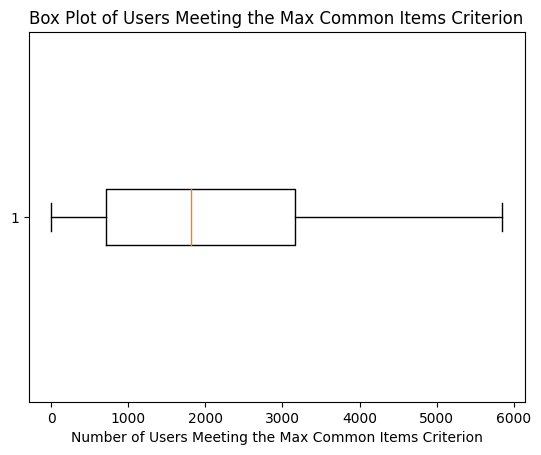

In [39]:
import matplotlib.pyplot as plt

# 최대 공통 아이템 수 기준 설정
max_common_items = 5

# 각 사용자별로 최대 공통 아이템 수 기준을 충족하는 다른 사용자의 수 계산
user_common_counts = [sum(1 for count in counts.values() if count <= max_common_items) for counts in common_items_count.values()]

# 히스토그램으로 시각화
plt.hist(user_common_counts, bins=25, edgecolor='black')
plt.xlabel('Number of Users Meeting the Max Common Items Criterion')
plt.ylabel('Frequency')
plt.title('Distribution of Users Meeting the Max Common Items Criterion')
plt.show()

# 박스 플롯으로 시각화
plt.boxplot(user_common_counts, vert=False)
plt.xlabel('Number of Users Meeting the Max Common Items Criterion')
plt.title('Box Plot of Users Meeting the Max Common Items Criterion')
plt.show()


In [36]:
ratings.groupby('user_id').count().describe(percentiles=[0.01, 0.02, 0.03, 0.04, 0.05])

,item_id,rating,timestamp
count,6040.000000,6040.000000,6040.000000
mean,165.597517,165.597517,165.597517
std,192.747029,192.747029,192.747029
min,20.000000,20.000000,20.000000
1%,20.000000,20.000000,20.000000
2%,21.000000,21.000000,21.000000
3%,22.000000,22.000000,22.000000
4%,22.000000,22.000000,22.000000
5%,23.000000,23.000000,23.000000
50%,96.000000,96.000000,96.000000


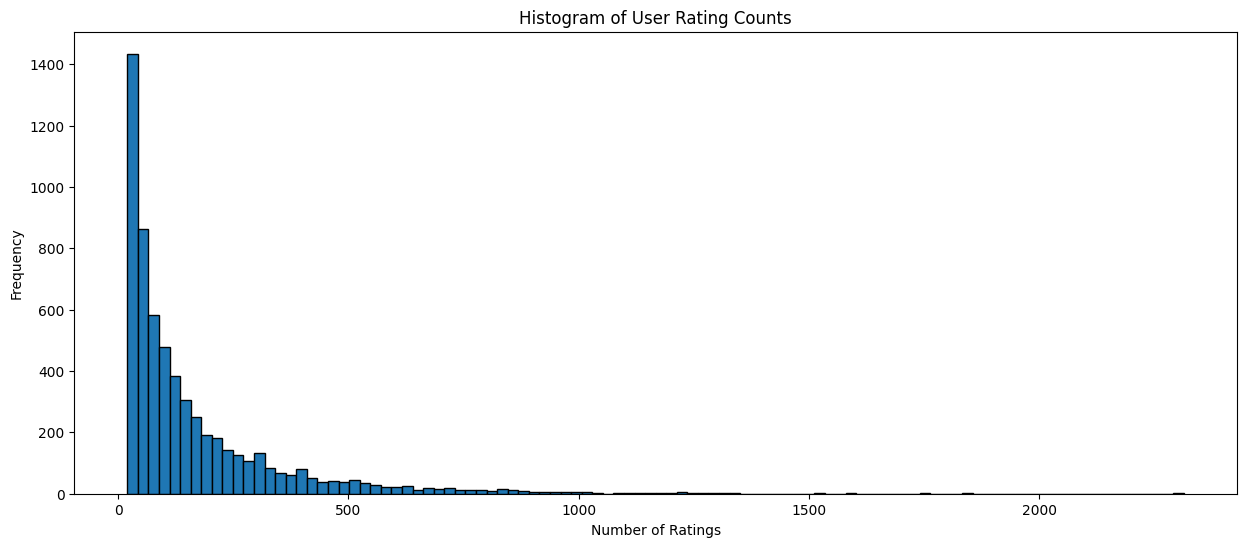

In [9]:
# import matplotlib.pyplot as plt

# # ratings라는 DataFrame이 있다고 가정하고, 각 사용자별로 평가한 아이템 수 계산
# user_rating_counts = ratings.groupby('user_id').count()

# # 기술적 통계량 시각화
# plt.figure(figsize=(15, 6))
# plt.hist(user_rating_counts['movie_id'], bins=100, edgecolor='black')
# plt.title("Histogram of User Rating Counts")
# plt.xlabel("Number of Ratings")
# plt.ylabel("Frequency")
# plt.show()

<AxesSubplot:xlabel='movie_id', ylabel='Density'>

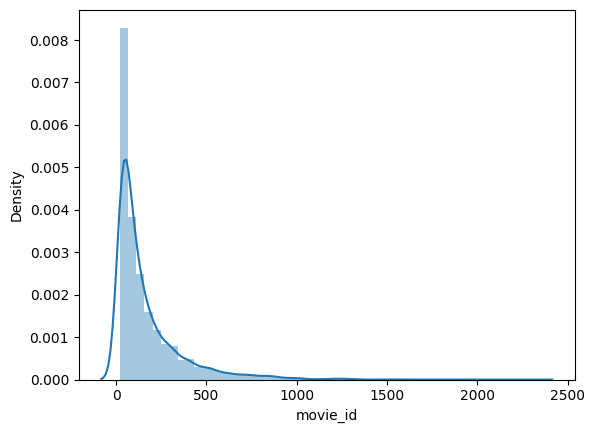

In [16]:
sns.distplot(pd.Series(ratings.groupby('user_id').count()['movie_id']))

In [27]:
plt.figure(figsize=(15, 6))
sns.kdeplot(pd.Series(ratings.groupby('user_id').count()['movie_id']), shade=True)
plt.title("Density Plot of User Rating Counts")
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.show()

NameError: name 'plt' is not defined

In [40]:
# 모든 사용자 쌍의 공통 아이템 수를 평균값 분포
average_common_items = [sum(inner_dict.values())/len(inner_dict) for inner_dict in common_items_count.values() if len(inner_dict)!=0]
pd.Series(average_common_items).describe(percentiles=[0.05, 0.1, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7, 0.75, 0.8])

count    6040.000000
mean       22.354856
std        20.454181
min         0.964895
5%          3.786132
10%         4.721874
20%         6.425070
25%         7.422669
30%         8.623464
40%        11.576321
50%        15.408843
60%        19.908164
70%        25.969035
75%        30.132514
80%        35.581686
max       138.999669
dtype: float64

<AxesSubplot:ylabel='Density'>

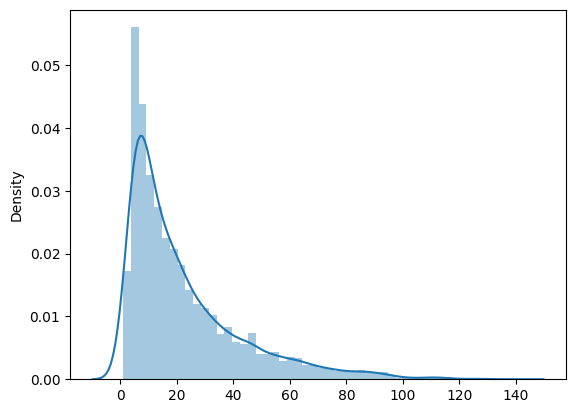

In [41]:
# Dist. viz
sns.distplot(pd.Series(average_common_items))

In [14]:
check_max = [max(inner_dict.values()) for inner_dict in common_items_count.values()]
pd.Series(check_max).describe()

count    6040.000000
mean      144.841722
std       159.394501
min        15.000000
25%        41.000000
50%        86.000000
75%       185.000000
max      1367.000000
dtype: float64

In [23]:
check_med = [np.median(list(inner_dict.values())) for inner_dict in common_items_count.values()]
pd.Series(check_med).describe()

count    6040.000000
mean       14.590894
std        12.694652
min         0.000000
25%         5.000000
50%        10.000000
75%        20.000000
max        81.000000
dtype: float64

In [18]:
def black(common_items_count, max_common_items, min_users):

    user_count = {}

    for user1, others in common_items_count.items():
        user_count[user1] = sum(1 for user2, count in others.items() if count >= max_common_items)

    qualifying_users = [user for user, count in user_count.items() if count < min_users]

    return qualifying_users

In [11]:
# len(common_items_count)

6040

In [19]:
result = black(common_items_count, 2, 1)
result

[]

# similarity calculation

In [6]:
# 사용자 잠재벡터 결과 DataFrame으로 변환
user_latent_vectors = pd.DataFrame(model.P, index=model.index_user_id.values())
user_latent_vectors

,0,1,2,3,4,5,6,7,8,9,...,210,211,212,213,214,215,216,217,218,219
1,0.028616,0.054727,-0.018807,0.027069,-0.038323,0.092853,-0.052780,-0.114760,0.045711,-0.065294,...,0.024002,-0.080979,0.050613,0.036771,0.070905,-0.007709,0.036345,0.006960,-0.031963,0.052081
2,0.067530,0.014960,-0.041391,-0.010992,-0.030395,-0.006045,0.031803,-0.139920,0.282032,-0.048604,...,0.096036,-0.014927,0.140416,-0.118626,0.027321,-0.045100,0.027934,0.088354,-0.137174,0.029695
3,0.025260,-0.017051,-0.052741,0.044435,-0.017418,-0.056218,0.094652,-0.102976,0.042401,-0.017222,...,0.064959,-0.041133,-0.084050,-0.111104,-0.054386,0.050376,0.070774,-0.087004,-0.048713,-0.077997
4,-0.019732,0.052508,0.016073,-0.010671,-0.059237,-0.029477,-0.048100,-0.022656,0.025836,0.033579,...,0.029769,0.024248,0.058131,0.079188,0.062858,-0.056736,-0.103261,-0.023505,0.043452,0.034943
5,-0.079720,-0.237963,0.006019,-0.011807,-0.100848,-0.117731,-0.225870,-0.065223,-0.174227,-0.034176,...,-0.168309,0.039817,-0.088858,0.147865,-0.159643,0.099100,-0.018685,0.062292,0.186308,-0.121645
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0.005294,-0.110579,0.105554,0.029327,0.050472,0.096596,-0.080360,0.111605,-0.047276,-0.012691,...,-0.072282,0.064702,0.070692,0.096683,-0.037964,0.008041,-0.078816,0.009556,0.073270,0.079222
6037,0.018413,0.089009,-0.054423,0.022233,-0.084662,0.084611,-0.038297,-0.001037,-0.024518,-0.028018,...,-0.006540,0.062292,0.102865,0.037152,-0.088514,0.067420,-0.064471,-0.028737,0.023563,0.087179
6038,0.023694,0.039173,0.050283,0.056728,0.088068,-0.012104,0.042905,-0.004441,0.092998,0.089431,...,0.042206,0.009170,-0.052618,0.014648,0.060543,-0.034054,-0.007096,-0.047845,-0.007487,-0.096960
6039,-0.107171,0.009716,0.028878,0.024527,-0.005718,0.057925,-0.013288,0.024067,0.038651,0.034669,...,0.031819,-0.082603,-0.063038,0.100101,0.011191,-0.058839,-0.036374,-0.082590,-0.059140,0.031772


In [64]:
# 사용자 간 유사도 (피어슨 상관계수) 
def pearson_similarity(user_latent_vectors):
    num_users = user_latent_vectors.shape[0]
    similarity_matrix = np.zeros((num_users, num_users))
    
    for i in range(num_users):
        for j in range(i, num_users):
            if np.all(user_latent_vectors[i] == 0) or np.all(user_latent_vectors[j] == 0):
                # If a user's latent vector is all zeros, set similarity to 0
                similarity = 0
            else:
                similarity, _ = pearsonr(user_latent_vectors[i], user_latent_vectors[j])
            
            similarity_matrix[i, j] = similarity
            similarity_matrix[j, i] = similarity  # Pearson correlation is symmetric
    
    return similarity_matrix


In [65]:
# 모든 사용자 쌍에 대한 [피어슨 상관계수] 계산
user_latent_vectors = model.P
pearson_matrix = pearson_similarity(user_latent_vectors)

# 유사도 DataFrame으로 변환 (인덱스와 칼럼에 user_id 할당)
pearson_df = pd.DataFrame(pearson_matrix, index=model.index_user_id.values(), columns=model.index_user_id.values())
pearson_df

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,0.234376,0.012511,0.141909,-0.376527,0.222910,0.019582,-0.032196,-0.045570,0.066757,...,-0.040702,-0.356626,0.307131,-0.152224,-0.222142,-0.181918,0.205056,-0.207891,0.009915,-0.018813
2,0.234376,1.000000,0.093975,-0.165412,-0.434944,0.189078,0.202860,-0.047742,0.174255,0.184869,...,0.226892,-0.143947,0.346302,-0.386439,0.178837,-0.023122,0.074604,-0.122556,0.178789,-0.246979
3,0.012511,0.093975,1.000000,-0.151468,-0.250776,0.333641,0.192967,-0.243454,-0.032907,0.118501,...,0.147238,-0.160115,0.027016,-0.275277,-0.136256,-0.436162,-0.222227,0.197163,0.094665,-0.179432
4,0.141909,-0.165412,-0.151468,1.000000,0.139315,-0.123531,-0.253103,0.010060,-0.187825,-0.338581,...,-0.581245,0.276599,-0.337429,0.547763,-0.095377,0.359955,0.179410,0.022721,-0.318112,0.539300
5,-0.376527,-0.434944,-0.250776,0.139315,1.000000,-0.241298,-0.305606,0.055382,-0.150204,-0.218296,...,-0.225770,0.374667,-0.335318,0.370558,0.178217,0.286575,0.175105,0.094160,-0.047517,0.102901
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.181918,-0.023122,-0.436162,0.359955,0.286575,-0.422270,-0.234068,0.222751,0.057613,-0.240559,...,-0.431974,0.385797,-0.217482,0.497275,0.137350,1.000000,0.106067,-0.038542,0.027560,0.384996
6037,0.205056,0.074604,-0.222227,0.179410,0.175105,-0.151880,-0.119721,0.122684,0.104116,-0.119854,...,-0.224628,0.038522,-0.023261,0.209405,-0.034535,0.106067,1.000000,-0.378035,0.109405,0.201304
6038,-0.207891,-0.122556,0.197163,0.022721,0.094160,0.150256,-0.104613,-0.215640,-0.208245,0.312624,...,-0.124249,0.476116,0.136711,0.130716,0.282368,-0.038542,-0.378035,1.000000,-0.001412,0.106799
6039,0.009915,0.178789,0.094665,-0.318112,-0.047517,0.053012,0.086112,-0.131816,-0.042888,0.243113,...,0.201500,-0.190717,0.139483,-0.135164,-0.032202,0.027560,0.109405,-0.001412,1.000000,0.070414


In [78]:
# Save model results
with open('/home/ryu/thesis/new_movielens/35_pearson_sim.pkl', 'wb') as f:
    pickle.dump(pearson_df, f)

In [19]:
# 모든 사용자 쌍에 대한 [코사인 유사도] 계산
user_latent_vectors = pd.DataFrame(model.P, index=model.index_user_id.values())
cosine_matrix = cosine_similarity(user_latent_vectors)

# 유사도 DataFrame으로 변환 (인덱스와 칼럼에 user_id 할당)
cosine_df = pd.DataFrame(cosine_matrix, index=user_latent_vectors.index, columns=user_latent_vectors.index)
cosine_df

,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
1,1.000000,0.323421,0.110158,0.213409,-0.289634,0.186515,0.138408,-0.084538,-0.063255,0.037501,...,0.185601,-0.335022,0.134007,-0.437562,-0.165235,-0.084247,0.309483,-0.343860,0.165582,-0.202672
2,0.323421,1.000000,0.287806,-0.124770,-0.340874,0.260820,0.012563,-0.097564,-0.136029,0.237673,...,0.218447,0.020623,0.218049,-0.310024,0.029304,-0.060902,0.216032,0.070261,0.173421,-0.200511
3,0.110158,0.287806,1.000000,-0.039894,-0.496155,0.204846,0.458852,-0.110058,-0.003448,-0.041312,...,0.204308,-0.312984,0.196305,-0.447335,-0.110806,-0.366922,-0.047471,0.207061,0.174259,-0.187614
4,0.213409,-0.124770,-0.039894,1.000000,0.115370,-0.025376,-0.026370,0.030469,-0.055563,-0.371805,...,-0.454017,0.125172,-0.301279,0.239756,-0.151644,0.289264,0.143096,-0.080954,-0.178806,0.324291
5,-0.289634,-0.340874,-0.496155,0.115370,1.000000,-0.166085,-0.410505,0.198387,-0.013855,-0.036535,...,-0.237724,0.154534,-0.269385,0.486184,0.102299,0.273893,-0.035012,-0.062212,-0.076247,0.195483
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,-0.084247,-0.060902,-0.366922,0.289264,0.273893,-0.312180,-0.274731,0.048985,0.071607,-0.291554,...,-0.475240,0.316079,-0.194349,0.354137,0.193001,1.000000,0.046561,-0.138770,0.100109,0.406237
6037,0.309483,0.216032,-0.047471,0.143096,-0.035012,0.032835,0.014857,0.039178,0.052381,-0.157373,...,-0.191928,-0.052050,-0.139269,-0.039889,0.112196,0.046561,1.000000,-0.272303,0.052580,0.016120
6038,-0.343860,0.070261,0.207061,-0.080954,-0.062212,0.213730,-0.232640,-0.238134,-0.244840,0.428907,...,0.017301,0.407042,0.366439,0.249262,0.087887,-0.138770,-0.272303,1.000000,-0.139367,0.080132
6039,0.165582,0.173421,0.174259,-0.178806,-0.076247,0.116035,0.121133,-0.148702,-0.037890,-0.044369,...,0.209304,-0.353310,-0.064049,-0.114036,-0.013804,0.100109,0.052580,-0.139367,1.000000,-0.135778


In [20]:
# Save model results
with open('/home/ryu/thesis/new_movielens/15_cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_df, f)

In [ ]:
# # 유사도 계산 결과 불러오기
# similarity_matrix = pd.read_csv('/home/ryu/thesis/test_movielens/cosine_sim.csv', index_col=0)
# similarity_matrix

In [67]:
with open('/home/ryu/thesis/new_movielens/84_cosine_sim.pkl', 'rb') as f:
    cosine_df = pickle.load(f)
with open('/home/ryu/thesis/new_movielens/84_pearson_sim.pkl', 'rb') as f:
    pearson_df = pickle.load(f)

In [68]:
# 사용자별 유사도 상위 n명의 데이터만 가지고 사용자 유사도 평균 계산
def average_similarity(similarity_matrix, user_ids, n):

    top_n_similarities = np.sort(similarity_matrix, axis=1)[:, -n-1:-1] # sort and take the top n, excluding the self-similarity
    average_similarities = np.mean(top_n_similarities, axis=1)

    # user_similarity_dict = {user_index+1: avg_sim for user_index, avg_sim in enumerate(average_similarities)}
    user_similarity_dict = {user_id: avg_sim for user_id, avg_sim in zip(user_ids, average_similarities)}
    average_similarity_df = pd.DataFrame(list(user_similarity_dict.items()), columns=['user_id', 'similarity_index'])

    return average_similarity_df

<AxesSubplot:xlabel='similarity_index', ylabel='Density'>

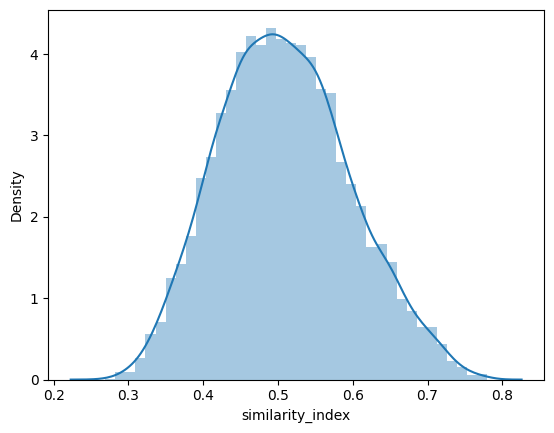

In [74]:
# 평균 유사도 결과 산출
avg_sim = average_similarity(cosine_df, cosine_df.index, 30)
# Distribution Visualization
sns.distplot(avg_sim['similarity_index'])# Dist. viz

In [75]:
# 유사도 평균 분포 확인
avg_sim['similarity_index'].describe()

count    6040.000000
mean        0.508928
std         0.088011
min         0.269070
25%         0.445121
50%         0.504624
75%         0.567666
max         0.779487
Name: similarity_index, dtype: float64

In [76]:
# 유사도 크기 순으로 나열
sim_values = sorted(list(avg_sim['similarity_index']))

# 사용자의 특정 비율에 해당하는 인덱스를 계산
percentiles = [i for i in range(1, 51)]
threshold_indices = [(100 - p) * len(sim_values) // 100 for p in percentiles]
# print(threshold_indices)

# 각 비율에 해당하는 threshold 값을 찾기.
thresholds = [sim_values[len(sim_values)-i] for i in threshold_indices]
# print(thresholds)

In [77]:
# 각 threshold에 대한 사용자 수와 비율을 계산
users_dict = {}

for percentile, threshold in zip(percentiles, thresholds):

    gsu = [user for user, sim in zip(avg_sim['user_id'], avg_sim['similarity_index']) if sim < threshold]

    print(f'Percentile {percentile}% - Threshold: {threshold:.6f}')
    print(f'Number of users below threshold: {len(gsu)}')
    # print(f'Proportion of users below threshold: {len(gsu) / len(avg_sim):.6f}\n')
    # print(f'Users below threshold: {gsu}\n')

    users_dict[f'{percentile}'] = gsu

Percentile 1% - Threshold: 0.330781
Number of users below threshold: 61
Percentile 2% - Threshold: 0.345818
Number of users below threshold: 121
Percentile 3% - Threshold: 0.356285
Number of users below threshold: 182
Percentile 4% - Threshold: 0.363117
Number of users below threshold: 242
Percentile 5% - Threshold: 0.371300
Number of users below threshold: 302
Percentile 6% - Threshold: 0.377229
Number of users below threshold: 363
Percentile 7% - Threshold: 0.382934
Number of users below threshold: 423
Percentile 8% - Threshold: 0.388213
Number of users below threshold: 484
Percentile 9% - Threshold: 0.393508
Number of users below threshold: 544
Percentile 10% - Threshold: 0.397245
Number of users below threshold: 604
Percentile 11% - Threshold: 0.401097
Number of users below threshold: 665
Percentile 12% - Threshold: 0.405492
Number of users below threshold: 725
Percentile 13% - Threshold: 0.409774
Number of users below threshold: 786
Percentile 14% - Threshold: 0.412768
Number of u

In [78]:
# Save model results
with open('/home/ryu/thesis/new_movielens/84_cosine_gsu.pkl', 'wb') as f:
    pickle.dump(users_dict, f)